In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


# **Import Data**

In [2]:
train_data = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv')
test_data = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv')
sample_data = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv')

In [3]:
# Make a copy of the data
train_df=train_data.copy()
test_df=test_data.copy()
sample_df=sample_data.copy()

In [4]:
# Check rows and columns of the data
print(train_df.shape)
print(test_df.shape)
print(sample_df.shape)

(13636, 15)
(4546, 14)
(1000, 2)


# **1. Data cleaning**

In [5]:
train_df.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


In [6]:
# Convert Timestamps to seconds, minutes ,hours
formatted_time = []
for ft in train_df['CreationTimestamp']:
    ft %= (24 * 3600)
    ft_hours = ft // 3600
    ft %= 3600
    ft_minutes =  ft// 60
    ft_seconds = ft % 60
    
    # To make it in the form of 'HH:MM:SS'
    format_ = f"{ft_hours:02d}:{ft_minutes:02d}:{ft_seconds:02d}"
    formatted_time.append(format_)

train_df['FormattedTimestamp'] = formatted_time

In [7]:
# Make Column 'Hour' using FormattedTimeStamp Column
train_df['Hour'] = pd.to_datetime(train_df['FormattedTimestamp'],format='%H:%M:%S').dt.hour
train_df.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review,FormattedTimestamp,Hour
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...,10:44:38,10
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...,10:57:32,10
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...,10:49:17,10
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...,15:48:19,15
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...,11:04:20,11


In [8]:
# Remove Unnecessary Columns
train_df.drop(['CommentID', 'UserID', 'UserName','ID','CreationTimestamp','FormattedTimestamp'], axis=1, inplace=True)

In [9]:
#Check for missing values
train_df.isna().sum()

RecipeNumber       0
RecipeCode         0
RecipeName         0
UserReputation     0
ReplyCount         0
ThumbsUpCount      0
ThumbsDownCount    0
Rating             0
BestScore          0
Recipe_Review      2
Hour               0
dtype: int64

In [10]:
train_df[train_df['Recipe_Review'].isna()]

,RecipeNumber,RecipeCode,RecipeName,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review,Hour
2984,6,21444,Favorite Chicken Potpie,1,0,0,0,5,100,NaN,10
11654,3,2832,Cheeseburger Soup,1,0,0,0,5,100,NaN,10


In [11]:
# Fill Missing values in Recipe Review
train_df['Recipe_Review'] = train_df['Recipe_Review'].fillna('great')

In [12]:
# Check Missing Values again 
train_df.isna().sum()

RecipeNumber       0
RecipeCode         0
RecipeName         0
UserReputation     0
ReplyCount         0
ThumbsUpCount      0
ThumbsDownCount    0
Rating             0
BestScore          0
Recipe_Review      0
Hour               0
dtype: int64

In [13]:
# Check Words from positive review having positive feedback
positive_words = ['delicious','amazing','fantastic','incredible','likes','perfect','liked','loves',
                  'yummy','perfect','wonderful','excellent','tasty','flavorful','mouthwatering',
                  'satisfying','terrific','impressive','hit','outstanding','best','great','easy',
                  'special','favorite','favourite','good','loved','super','awesome','fab','fabulous',
                 'easy','simple','sweet','yum','love','like','enjoy','enjoyed']

In [14]:
pattern = '|'.join(positive_words)
# To count the rows which contains any of words from recipe review
rows_with_positive_words = train_df['Recipe_Review'].str.lower().str.contains(pattern).sum()

In [15]:
rows_with_positive_words

12211

In [16]:
# Count the rows having 2,3,4 and 5 rating
train_df[(train_df['Rating'] == 5) | (train_df['Rating'] == 4) | (train_df['Rating'] == 3) | (train_df['Rating'] == 2)].shape[0]

12154

In [17]:
# Create a new column with value 1 if any of the words are present in the recipe review, else 0
train_df['Positive_Review'] = np.where(train_df['Recipe_Review'].str.lower().str.contains('|'.join(positive_words), case=False), 1, 0)
train_df.head()

,RecipeNumber,RecipeCode,RecipeName,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review,Hour,Positive_Review
0,71,12259,Banana Bars with Cream Cheese Frosting,20,0,0,0,5,100,great recipe! I have made them just as written...,10,1
1,88,8202,Simple Taco Soup,1,0,0,1,5,100,This is an easy and quick recipe that is great...,10,1
2,3,2832,Cheeseburger Soup,1,0,0,0,3,100,I think I was looking for something extra spec...,10,1
3,50,100276,Grilled Huli Huli Chicken,1,0,0,0,5,100,This is our favorite grilled chicken recipe. ...,15,1
4,12,19731,Cauliflower Soup,1,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...,11,1


In [18]:
# Define a function to clean text data 

def cleaner(text):
    text = text.lower()  # converting text to lower
    text = re.sub(r'[^\w\s]', '', text)  # Removing punctuations
    stop_words = set([  
      "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
      "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it",
      "its", "itself", "they", "them", "theirs", "themselves", "what", "which", "who",
      "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be",
      "been", "having", "has", "have", "had", "shall", "will", "should", "would", "may",
      "might", "must", "can", "could", "ought", "do", "does", "did", "done", "have", "has",
      "had", "having", "be", "been", "a", "an", "the", "of", "and", "to", "in", "on", "for",
      "is", "as", "with", "by", "at", "because", "but", "or", "that", "which", "who", "this",
      "them", "selves", "if", "after", "before", "until", "though", "while", "how", "all",
      "any", "both", "each", "few", "more", "most", "some", "such", "no", "nor", "not", "only",
      "own", "same", "so", "than", "too", "very", "have", "has", "had", "having", "be", "been"  
    ])
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [19]:
import re
# Clean recipe reviews
train_df['Recipe_Review_Clean'] = train_df['Recipe_Review'].apply(cleaner)
test_df['Recipe_Review_Clean'] = test_df['Recipe_Review'].apply(cleaner)

In [20]:
def positive_word_finder(text, positive_words):
    found_words = []
    for i in positive_words:
        if i.lower() in text.lower():  
            found_words.append(i)
            return ", ".join(found_words)  # Join found words with comma separation

# Add a new column named 'Review_sentiment'
train_df['Review_sentiment'] = train_df['Recipe_Review'].apply(positive_word_finder, args=(positive_words,))


In [21]:
train_df["Review_sentiment"].unique()

array(['wonderful', 'great', 'special', 'delicious', 'good', 'amazing',
       None, 'favorite', 'hit', 'yummy', 'flavorful', 'excellent',
       'liked', 'tasty', 'perfect', 'loved', 'easy', 'fantastic', 'sweet',
       'loves', 'best', 'like', 'love', 'awesome', 'incredible', 'enjoy',
       'likes', 'fab', 'yum', 'outstanding', 'simple', 'favourite',
       'terrific', 'super', 'satisfying', 'impressive', 'mouthwatering'],
      dtype=object)

In [22]:
train_df.head()

,RecipeNumber,RecipeCode,RecipeName,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review,Hour,Positive_Review,Recipe_Review_Clean,Review_sentiment
0,71,12259,Banana Bars with Cream Cheese Frosting,20,0,0,0,5,100,great recipe! I have made them just as written...,10,1,great recipe made just written wonderfull mois...,wonderful
1,88,8202,Simple Taco Soup,1,0,0,1,5,100,This is an easy and quick recipe that is great...,10,1,easy quick recipe great fall cool weather made...,great
2,3,2832,Cheeseburger Soup,1,0,0,0,3,100,I think I was looking for something extra spec...,10,1,think looking something extra special soup was...,special
3,50,100276,Grilled Huli Huli Chicken,1,0,0,0,5,100,This is our favorite grilled chicken recipe. ...,15,1,favorite grilled chicken recipe great flavor,great
4,12,19731,Cauliflower Soup,1,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...,11,1,great basic recipe added 2 teaspoons tuscan se...,great


In [23]:
train_df.drop(['Recipe_Review'], axis=1, inplace=True)

In [24]:
# Transform Review_sentiment using LabelEncoder
label_encoder = LabelEncoder()

train_df["Review_sentiment"] = label_encoder.fit_transform(train_df['Review_sentiment'])

In [25]:
train_df.head()

,RecipeNumber,RecipeCode,RecipeName,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Hour,Positive_Review,Recipe_Review_Clean,Review_sentiment
0,71,12259,Banana Bars with Cream Cheese Frosting,20,0,0,0,5,100,10,1,great recipe made just written wonderfull mois...,33
1,88,8202,Simple Taco Soup,1,0,0,1,5,100,10,1,easy quick recipe great fall cool weather made...,13
2,3,2832,Cheeseburger Soup,1,0,0,0,3,100,10,1,think looking something extra special soup was...,28
3,50,100276,Grilled Huli Huli Chicken,1,0,0,0,5,100,15,1,favorite grilled chicken recipe great flavor,13
4,12,19731,Cauliflower Soup,1,0,0,0,4,100,11,1,great basic recipe added 2 teaspoons tuscan se...,13


In [26]:
#Check for missing values
train_df.isna().sum()

RecipeNumber           0
RecipeCode             0
RecipeName             0
UserReputation         0
ReplyCount             0
ThumbsUpCount          0
ThumbsDownCount        0
Rating                 0
BestScore              0
Hour                   0
Positive_Review        0
Recipe_Review_Clean    0
Review_sentiment       0
dtype: int64

# **2. Exploring train dataset**

In [27]:
# Print data with its shape
print(train_df.shape)
train_df.head()

(13636, 13)


,RecipeNumber,RecipeCode,RecipeName,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Hour,Positive_Review,Recipe_Review_Clean,Review_sentiment
0,71,12259,Banana Bars with Cream Cheese Frosting,20,0,0,0,5,100,10,1,great recipe made just written wonderfull mois...,33
1,88,8202,Simple Taco Soup,1,0,0,1,5,100,10,1,easy quick recipe great fall cool weather made...,13
2,3,2832,Cheeseburger Soup,1,0,0,0,3,100,10,1,think looking something extra special soup was...,28
3,50,100276,Grilled Huli Huli Chicken,1,0,0,0,5,100,15,1,favorite grilled chicken recipe great flavor,13
4,12,19731,Cauliflower Soup,1,0,0,0,4,100,11,1,great basic recipe added 2 teaspoons tuscan se...,13


In [28]:
# Information about train data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   RecipeNumber         13636 non-null  int64 
 1   RecipeCode           13636 non-null  int64 
 2   RecipeName           13636 non-null  object
 3   UserReputation       13636 non-null  int64 
 4   ReplyCount           13636 non-null  int64 
 5   ThumbsUpCount        13636 non-null  int64 
 6   ThumbsDownCount      13636 non-null  int64 
 7   Rating               13636 non-null  int64 
 8   BestScore            13636 non-null  int64 
 9   Hour                 13636 non-null  int32 
 10  Positive_Review      13636 non-null  int64 
 11  Recipe_Review_Clean  13636 non-null  object
 12  Review_sentiment     13636 non-null  int64 
dtypes: int32(1), int64(10), object(2)
memory usage: 1.3+ MB


In [29]:
#Descriptive Statistics
train_df.describe()

,RecipeNumber,RecipeCode,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Hour,Positive_Review,Review_sentiment
count,13636.000000,13636.000000,13636.000000,13636.000000,13636.000000,13636.000000,13636.000000,13636.000000,13636.000000,13636.000000,13636.000000
mean,38.624377,21785.990833,2.160311,0.014520,1.098269,0.543708,4.288721,153.127897,10.634717,0.895497,15.563068
std,29.672351,23883.189918,10.086424,0.137323,4.166487,3.265660,1.544839,140.986908,2.069485,0.305923,11.913429
min,1.000000,386.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,6504.000000,1.000000,0.000000,0.000000,0.000000,5.000000,100.000000,10.000000,1.000000,3.000000
50%,33.000000,14600.000000,1.000000,0.000000,0.000000,0.000000,5.000000,100.000000,10.000000,1.000000,13.000000
75%,63.000000,33121.000000,1.000000,0.000000,0.000000,0.000000,5.000000,100.000000,11.000000,1.000000,25.000000
max,100.000000,191775.000000,510.000000,3.000000,80.000000,126.000000,5.000000,946.000000,23.000000,1.000000,36.000000


In [30]:
# Occurrence of Rating in Data in percentages
(train_df['Rating'].value_counts() / len(train_df["Rating"]))*100

Rating
5    76.056028
0     9.328249
4     9.100909
3     2.698739
1     1.540041
2     1.276034
Name: count, dtype: float64

In [31]:
# Remove RecipeName and Recipe_Review_Clean for correlation matrix
train_df_num = train_df.drop(['RecipeName','Recipe_Review_Clean'],axis=1)
train_df_num.head()

,RecipeNumber,RecipeCode,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Hour,Positive_Review,Review_sentiment
0,71,12259,20,0,0,0,5,100,10,1,33
1,88,8202,1,0,0,1,5,100,10,1,13
2,3,2832,1,0,0,0,3,100,10,1,28
3,50,100276,1,0,0,0,5,100,15,1,13
4,12,19731,1,0,0,0,4,100,11,1,13


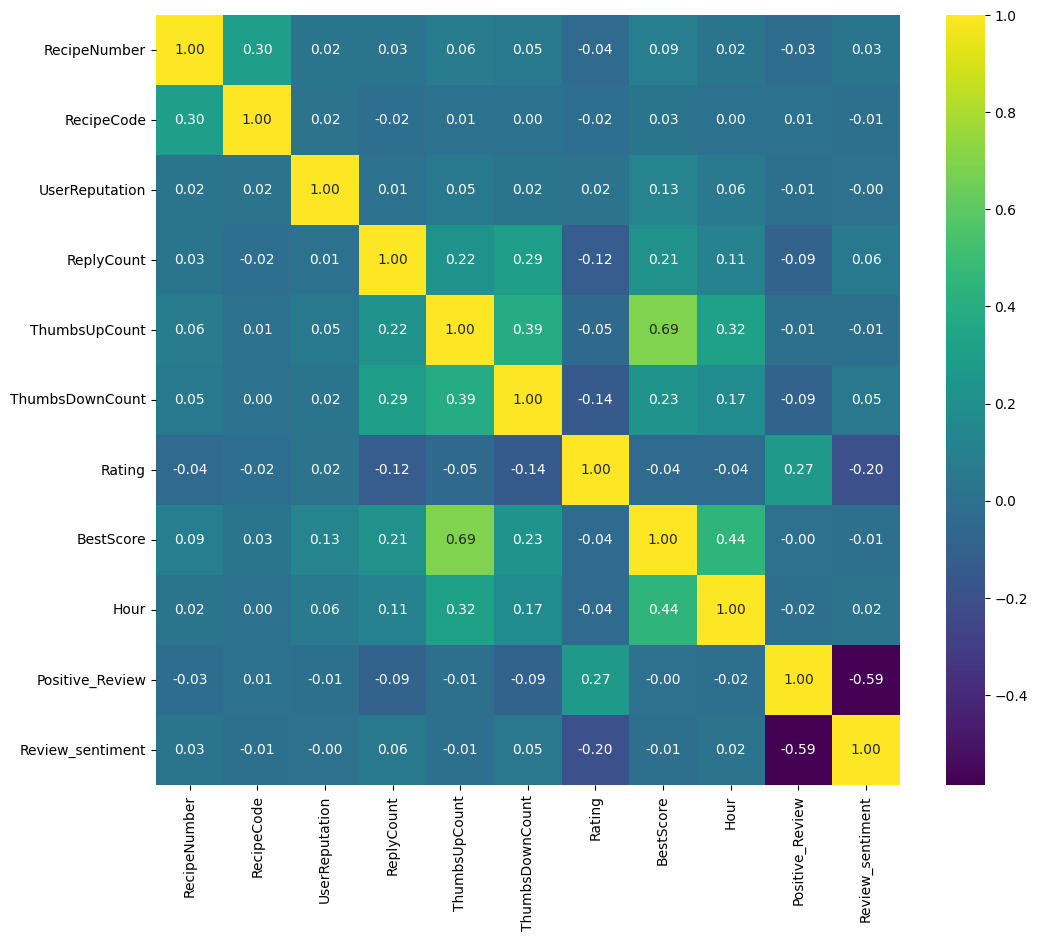

In [32]:
# Correlation between different columns of the data
corr_matrix = train_df_num.corr()
x_labels = train_df_num.columns
y_labels = train_df_num.columns
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis', xticklabels=x_labels, yticklabels=y_labels)
plt.show()

We can observe here that the correlation of Rating is high with Review_sentiment, Positive_Review,ThumbsDownCount and ReplyCount.

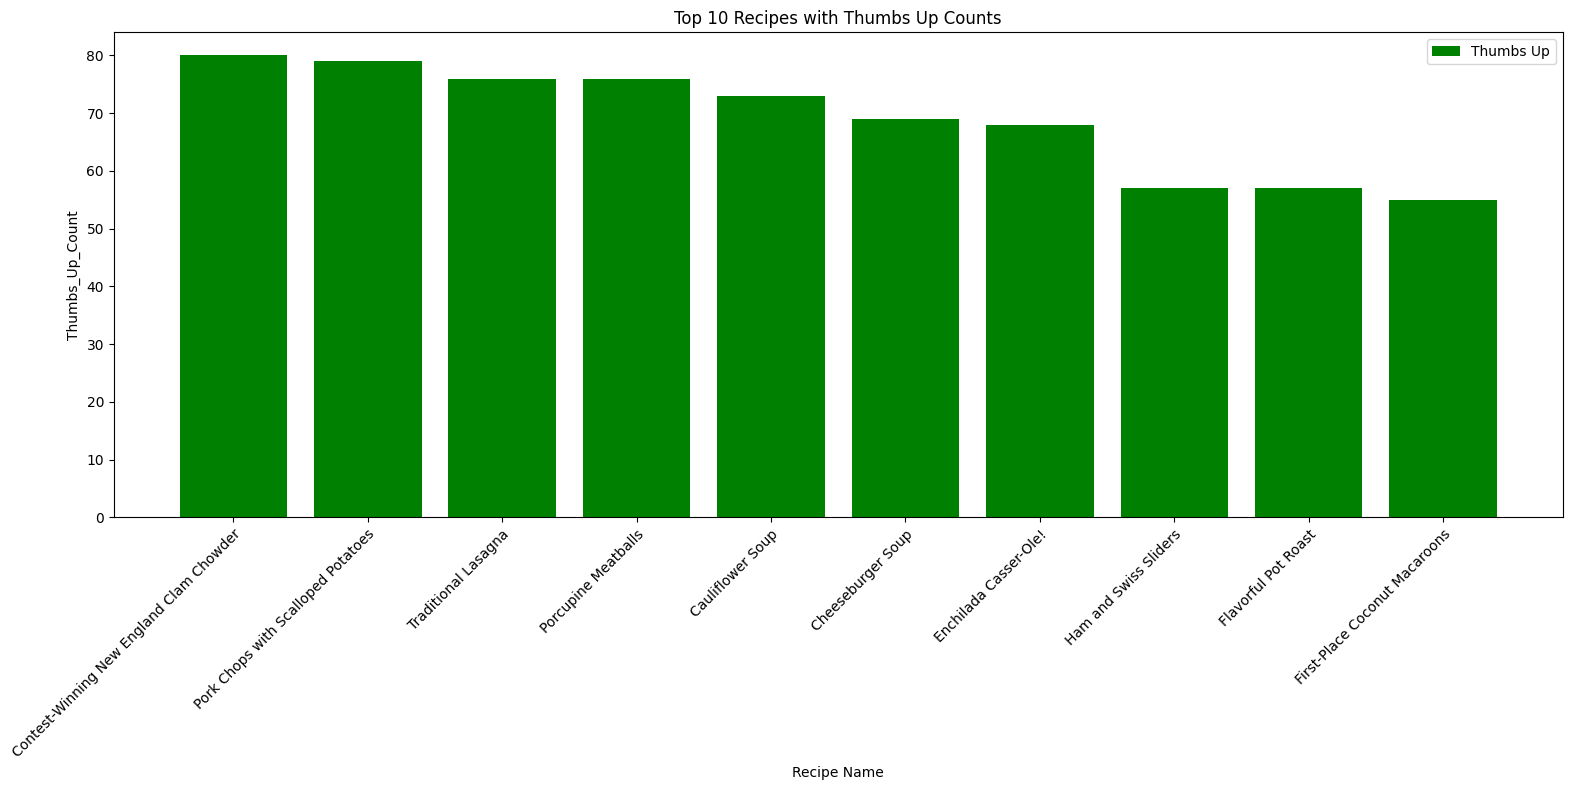

In [33]:
# Displayig top 10 Recipes with thumbs up 
# Sort the DataFrame by 'ThumbsUpCount' in descending order
sortby_thumbsup = train_df.sort_values(by='ThumbsUpCount', ascending=False)

# To get top 10 recipes
top10_recipes = sortby_thumbsup.head(10)

index = np.arange(len(top10_recipes))
plt.figure(figsize=(16, 8))
plt.bar(index, top10_recipes['ThumbsUpCount'], label='Thumbs Up', color='green')
plt.xlabel('Recipe Name')
plt.ylabel('Thumbs_Up_Count')
plt.title('Top 10 Recipes with Thumbs Up Counts')
plt.xticks(index , top10_recipes['RecipeName'], rotation=45, ha='right', rotation_mode='anchor')
plt.legend()
plt.tight_layout()
plt.show()

We can observe that Contest Winning New England Clam Chowder has got highest thumbs up while First Place Coconut Macaroons has got lowest thumbs up.

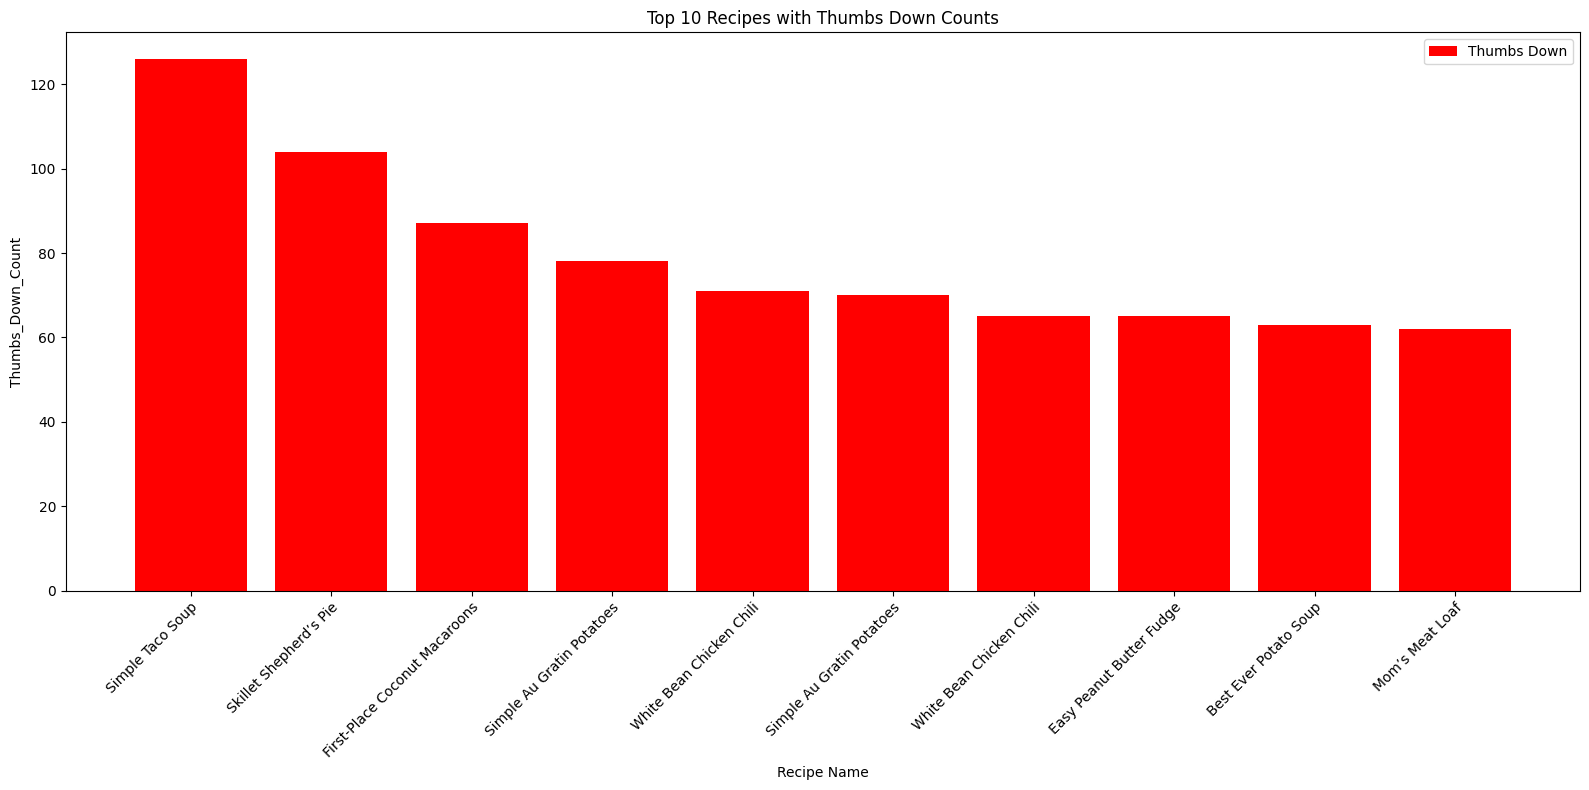

In [34]:
# Displayig top 10 Recipes with thumbs down 
# Sort the DataFrame by 'ThumbsDownCount' in descending order
sortby_thumbsdown = train_df.sort_values(by='ThumbsDownCount', ascending=False)

# To get top 10 recipes
top10_recipes = sortby_thumbsdown.head(10)

index = np.arange(len(top10_recipes))
plt.figure(figsize=(16, 8))
plt.bar(index, top10_recipes['ThumbsDownCount'], label='Thumbs Down', color='red')
plt.xlabel('Recipe Name')
plt.ylabel('Thumbs_Down_Count')
plt.title('Top 10 Recipes with Thumbs Down Counts')
plt.xticks(index , top10_recipes['RecipeName'], rotation=45, ha='right', rotation_mode='anchor')
plt.legend()
plt.tight_layout()
plt.show()

We can observe that Simple Taco Soup has highest thumbs down while Mom's Meat Loaf has lowest thumbs down.

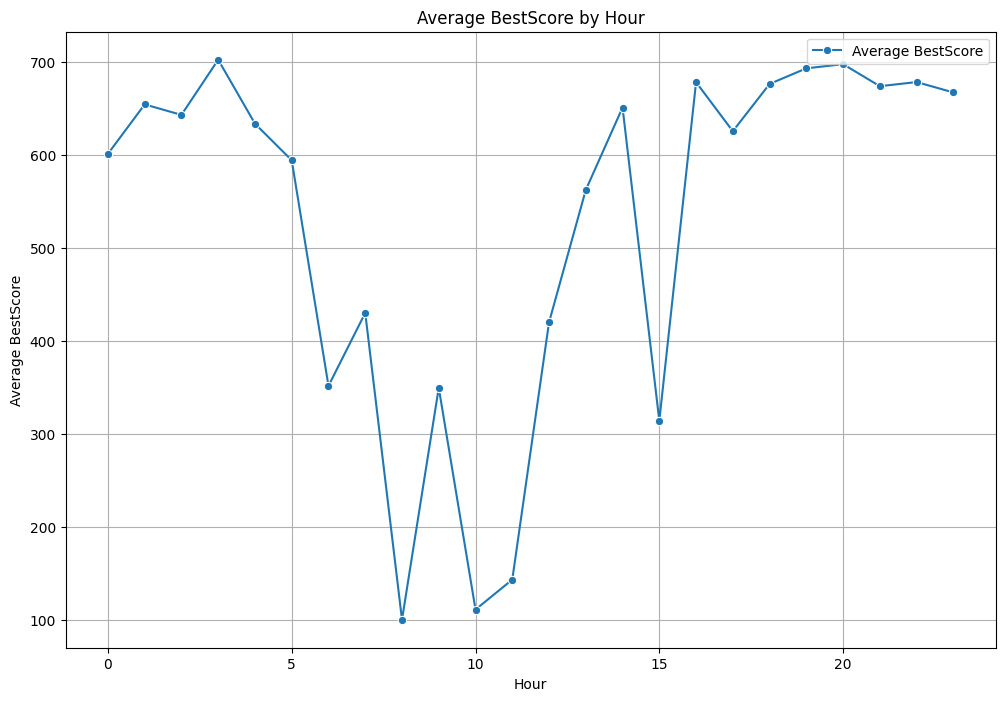

In [35]:
# Average BestScore by Hour

# Selecting relevant columns
hr_bestscore_df = train_df[['Hour', 'BestScore']]

# Calculate average best score by hour
avg_bestscore = hr_bestscore_df.groupby('Hour').mean().reset_index()
plt.figure(figsize=(12, 8))
sns.lineplot(data=avg_bestscore, x='Hour', y='BestScore', marker='o', label='Average BestScore')
plt.title('Average BestScore by Hour')
plt.xlabel('Hour')
plt.ylabel('Average BestScore')
plt.grid(True)
plt.show()

We can observe that the average best score decreases from the hour 5 to 10 and then it increases.

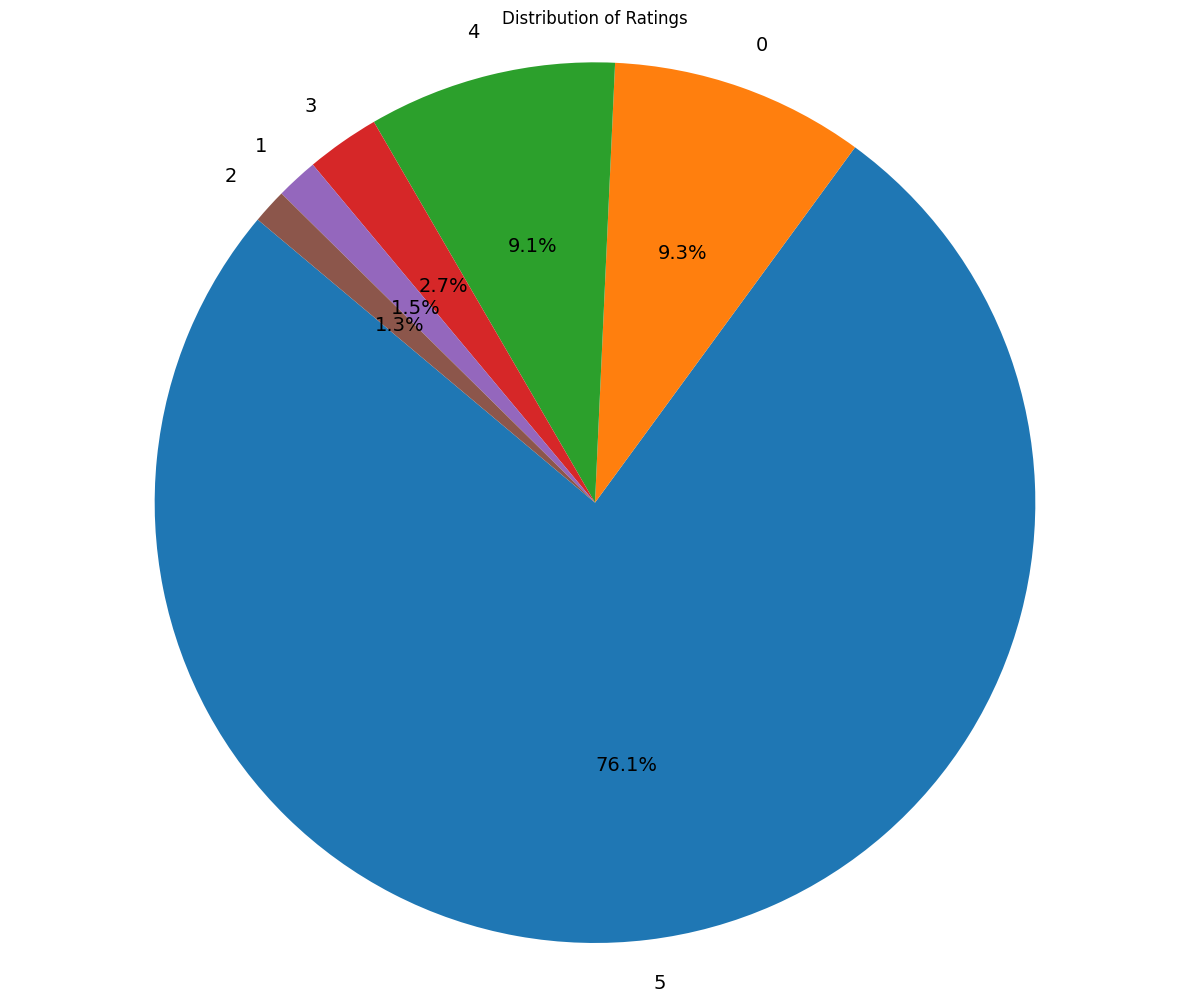

In [36]:
# Plot pie chart indicating occurrence of each rating and adjust its size and labels

rating_counts = train_df['Rating'].value_counts()
plt.figure(figsize=(12,10))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14})
plt.title('Distribution of Ratings')
plt.axis('equal')  
plt.tight_layout()
plt.show()

As we can observe 76% of the recipes have a rating of 5 so,the label distribution is not uniform, we will use stratified sampling.

In [37]:
#Use Stratified Sampling 
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=66)
for train_index, test_index in sss.split(train_df, train_df["Rating"]):
    train_index_list = list(train_index)
    train_df_reset_index = train_df.reset_index(drop=True)
    strat_train_set = train_df_reset_index.loc[train_index_list]
    strat_test_set = train_df_reset_index.loc[test_index]
    print(strat_train_set.shape, strat_test_set.shape)

(10908, 13) (2728, 13)


In [38]:
# Percentage of occurrence of each rating
rate_dist = (strat_test_set["Rating"].value_counts() / len(strat_test_set["Rating"]) )*100
rate_dist

Rating
5    76.063050
0     9.310850
4     9.090909
3     2.712610
1     1.539589
2     1.282991
Name: count, dtype: float64

# ML Algorithm

In [39]:
# Keeping all features except Rating in x_train and x_test
x_train = strat_train_set.drop("Rating", axis=1)
x_test = strat_test_set.drop("Rating", axis=1)

# Keeping only Rating feature in y_train and y_test
y_train = strat_train_set['Rating'].copy()
y_test = strat_test_set['Rating'].copy()

# **2. Preprocessing the columns**

In [40]:
# Preprocessing columns using StandardScaler()
std_scaler = StandardScaler()

# Separating 'RecipeName' and 'Recipe_Review_Clean' columns
X_train_recipe = x_train['RecipeName'].astype(str)
X_test_recipe = x_test['RecipeName'].astype(str)

X_train_sent = x_train['Recipe_Review_Clean'].astype(str)
X_test_sent = x_test['Recipe_Review_Clean'].astype(str)

# Remove 'RecipeName' and 'Recipe_Review_Clean' columns before scaling
X_train_scaled = x_train.drop(["RecipeName","Recipe_Review_Clean"], axis=1)
X_test_scaled = x_test.drop(["RecipeName","Recipe_Review_Clean"], axis=1)

# Now, Fit and transform training data
X_train_scaled = std_scaler.fit_transform(X_train_scaled)

# Also, Transform test data 
X_test_scaled = std_scaler.transform(X_test_scaled)

In [41]:
# Use TF-IDF Vectorizer 
vectorizer = TfidfVectorizer()
X_train_recipe_vec = vectorizer.fit_transform(X_train_recipe)
X_test_recipe_vec = vectorizer.transform(X_test_recipe)

X_train_sent_vec = vectorizer.fit_transform(X_train_sent)
X_test_sent_vec = vectorizer.transform(X_test_sent)

X_train_combined=np.hstack([X_train_scaled,X_train_recipe_vec.toarray(),X_train_sent_vec.toarray()])
X_test_combined=np.hstack([X_test_scaled,X_test_recipe_vec.toarray(),X_test_sent_vec.toarray()])

In [42]:
# Check shape of X_train_combined 
X_train_combined.shape

(10908, 12490)

In [43]:
# Check shape of X_test_combined
X_test_combined.shape

(2728, 12490)

# **Logistic Regression**

In [44]:
logistic_model = LogisticRegression(multi_class='ovr',max_iter=5000)

# Fit and Predict Logistic Regression
logistic_model.fit(X_train_combined, y_train)
y_pred_train_lg=logistic_model.predict(X_train_combined)
y_pred_test_lg=logistic_model.predict(X_test_combined)

# Determing Training and Testing Accuracy
print('Training Accuracy: ',accuracy_score(y_train, y_pred_train_lg)*100)
print('Testing Accuracy: ',accuracy_score(y_test, y_pred_test_lg)*100)

Training Accuracy:  80.17968463513017
Testing Accuracy:  77.23607038123167


**Training Accuracy:**

The model achieved an accuracy of 80.17% using training data which means that the model made 80% correct predications out of every 100 training examples.

**Testing Accuracy:**

The model achieved an accuracy of 77.24% indicating that when it is applied to test data, it's accuracy drops slightly.

In [45]:
# Make Classification Report
print(classification_report(y_test,y_pred_test_lg))

              precision    recall  f1-score   support

           0       0.46      0.17      0.25       254
           1       0.45      0.12      0.19        42
           2       0.00      0.00      0.00        35
           3       0.40      0.03      0.05        74
           4       0.35      0.06      0.10       248
           5       0.79      0.98      0.88      2075

    accuracy                           0.77      2728
   macro avg       0.41      0.23      0.24      2728
weighted avg       0.70      0.77      0.70      2728



It is observed that :
1. Precision of class 0 is 0.46 which indicates that 46% were truly class 0 out of all predications labelled as 0.
2. Recall of class 0 is 0.17 which indicates that model correctly identifies only 17% out of all actual class 0 instances.
3. Class 5 having highest support which is 2075 indicates that it has the most examples in the dataset.
4. F1 Score indicates how well model has performed in indicating a particular class.
5. The model achieved an accuracy of 77%.

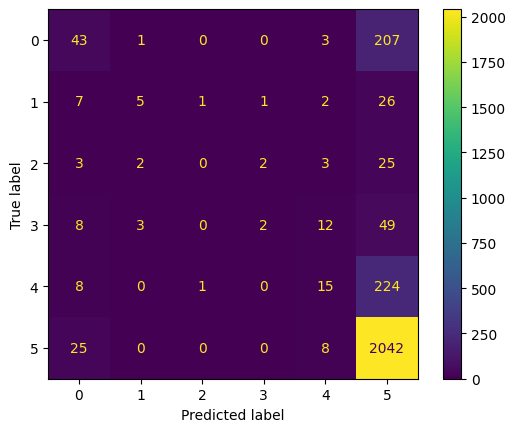

In [46]:
# Generate Confusion Matrix
print(ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test_lg))

It shows that 2042 instances are correctly identified instances of label 5. Also, 224 instances are predicted as label 5 but are actually label 4 and 8 instances are actually label 5 but are predicted as label 4.

# **Decision Tree**

In [47]:
#Decision tree classifier
DTmodel=DecisionTreeClassifier()
DTmodel.fit(X_train_combined, y_train)
y_pred_test_dt=DTmodel.predict(X_test_combined)
print('Testing Accuracy: ',accuracy_score(y_test, y_pred_test_dt)*100)

Testing Accuracy:  69.20821114369502


The model achieved an accuracy of 69.02% indicating that 69% correct predictions have been made by the model for every 100 examples in the testing data.

In [48]:
print(classification_report(y_test,y_pred_test_dt))

              precision    recall  f1-score   support

           0       0.26      0.25      0.26       254
           1       0.23      0.19      0.21        42
           2       0.18      0.09      0.12        35
           3       0.18      0.14      0.16        74
           4       0.21      0.20      0.21       248
           5       0.82      0.85      0.83      2075

    accuracy                           0.69      2728
   macro avg       0.31      0.28      0.30      2728
weighted avg       0.68      0.69      0.68      2728



It is observed that :
1. Precision of class 0 is 0.26 which indicates that 26% were truly class 0 out of all predications labelled as 0.
2. Recall of class 0 is 0.25 which indicates that model correctly identifies only 25% out of all actual class 0 instances.
3. Class 5 having highest support which is 2075 indicates that it has the most examples in the dataset.
4. F1 Score indicates how well model has performed in indicating a particular class.
5. The model achieved an accuracy of 69%.

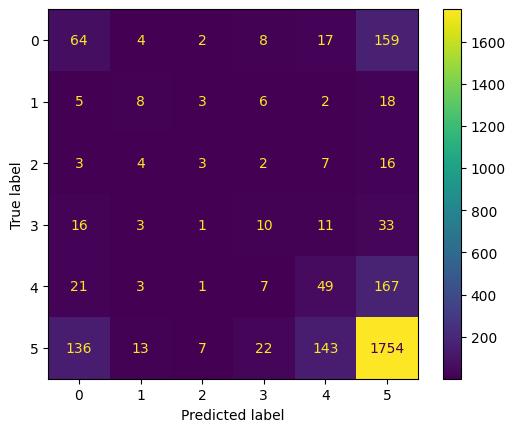

In [49]:
print(ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test_dt))

It shows that 1754 instances are correctly identified instances of label 5. Also, 167 instances are predicted as label 5 but are actually label 4 and 143 instances are actually label 5 but are predicted as label 4.

# **Random Forest**

In [50]:
param_grid = {
    'n_estimators': [100,200],  # Number of trees in the forest
    'max_depth': [10,20,30],      # Maximum depth of the trees
    'min_samples_split': [2,5],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2,3,5],    # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],# Number of features to consider when looking for the best split
    'bootstrap': [True, False]        # Whether bootstrap samples are used when building trees
}

In [51]:
# HYPERPARAMETER FINETUNING

# grid_search = GridSearchCV(RandomForestClassifier(),param_grid=param_grid,cv=3,verbose=3) 
# grid_search.fit(X_train_combined, y_train)
# best_param=grid_search.best_estimator_
# print(best_param) 

In [52]:
#Apply Random Forest Classifier
RFmodel=RandomForestClassifier(n_estimators=100,random_state=80)
RFmodel.fit(X_train_combined, y_train)
y_pred_test_rf=RFmodel.predict(X_test_combined)

# Determing Testing Accuracy
print('Testing Accuracy: ',accuracy_score(y_test, y_pred_test_rf)*100)

Testing Accuracy:  77.82258064516128


The model achieved an accuracy of 77.82% indicating that 77% correct predictions have been made by the model for every 100 examples in the testing data.

In [53]:
# Generate Classification Report
print(classification_report(y_test,y_pred_test_rf))

              precision    recall  f1-score   support

           0       0.64      0.14      0.23       254
           1       0.67      0.10      0.17        42
           2       0.00      0.00      0.00        35
           3       0.86      0.08      0.15        74
           4       0.91      0.04      0.08       248
           5       0.78      1.00      0.88      2075

    accuracy                           0.78      2728
   macro avg       0.64      0.23      0.25      2728
weighted avg       0.77      0.78      0.70      2728



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


It is observed that :
1. Precision of class 0 is 0.64 which indicates that 64% were truly class 0 out of all predications labelled as 0.
2. Recall of class 0 is 0.14 which indicates that model correctly identifies only 14% out of all actual class 0 instances.
3. Class 5 having highest support which is 2075 indicates that it has the most examples in the dataset.
4. F1 Score indicates how well model has performed in indicating a particular class.
5. The model achieved an accuracy of 78%.

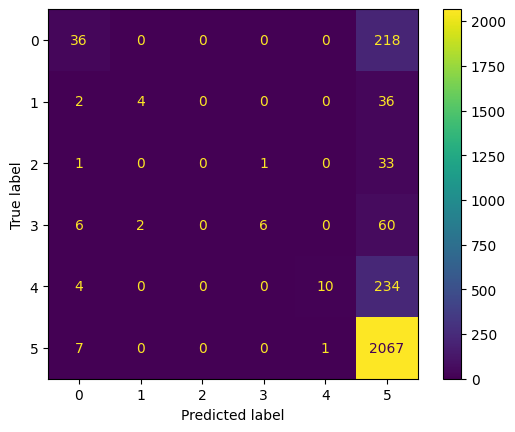

In [54]:
# Generate Confusion Matrix
print(ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test_rf))

It shows that 2067 instances are correctly identified instances of label 5. Also, 234 instances are predicted as label 5 but are actually label 4 and 1 instance is actually label 5 but is predicted as label 4.

# XGBOOST

In [55]:
param_grid3={
    'objective': ['multi:softmax'],  # Objective function for classification (binary for logistic regression)
    'n_estimators':[100,200],  # Number of boosting rounds (trees)
    'learning_rate':[0.1,0.2],  # Controls step size in each update to the model
    'max_depth':[2,3],  # Maximum depth of individual trees
    'min_child_weight':[0,0.1,0.2]  # Minimum sum of hessian (second derivative of loss) in a child node
}

In [56]:
# xgb_grid = GridSearchCV(XGBClassifier(),param_grid=param_grid3,cv=3,verbose=3) 
# xgb_grid.fit(X_train_combined, y_train)
# best_param=xgb_grid.best_estimator_
# print(best_param) 

In [57]:
# Apply XGBoost Model
xgbmodel=XGBClassifier(objective='multi:softmax',n_estimators=200,learning_rate=0.2,max_depth=2,
                  min_child_weight=0,random_state=81)

# Fitting and predication using XGBoost Model
xgbmodel.fit(X_train_combined,y_train)
y_pred_train_xgb=xgbmodel.predict(X_train_combined)
y_pred_test_xgb = xgbmodel.predict(X_test_combined)

# Determing Training and Testing Accuracy
print('Training Accuracy: ',accuracy_score(y_train, y_pred_train_xgb)*100)
print('Testing Accuracy: ',accuracy_score(y_test, y_pred_test_xgb)*100)

Training Accuracy:  80.78474514118078
Testing Accuracy:  77.41935483870968


**Training Accuracy:**

The model achieved an accuracy of 80.78% using training data which means that the model made 80% correct predications out of every 100 training examples.

**Testing Accuracy:**

The model achieved an accuracy of 77.41% indicating that when it is applied to test data, it's accuracy drops slightly.

In [58]:
# Generate Classification Report
print(classification_report(y_test,y_pred_test_xgb))

              precision    recall  f1-score   support

           0       0.52      0.15      0.23       254
           1       0.55      0.26      0.35        42
           2       0.00      0.00      0.00        35
           3       0.31      0.05      0.09        74
           4       0.35      0.03      0.05       248
           5       0.79      0.99      0.88      2075

    accuracy                           0.77      2728
   macro avg       0.42      0.25      0.27      2728
weighted avg       0.70      0.77      0.70      2728



It is observed that :
1. Precision of class 0 is 0.52 which indicates that 52% were truly class 0 out of all predications labelled as 0.
2. Recall of class 0 is 0.15 which indicates that model correctly identifies only 17% out of all actual class 0 instances.
3. Class 5 having highest support which is 2075 indicates that it has the most examples in the dataset.
4. F1 Score indicates how well model has performed in indicating a particular class.
5. The model achieved an accuracy of 77%.

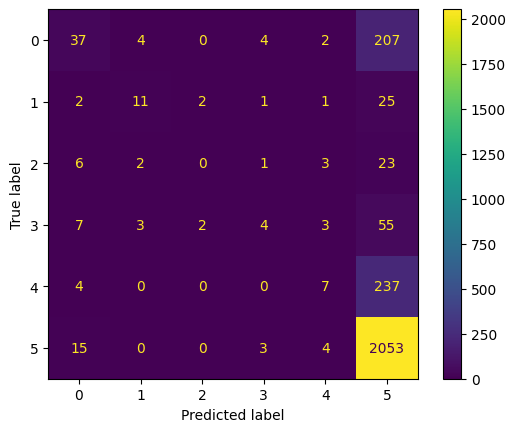

In [59]:
# Generate Confusion Matrix
print(ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test_xgb))

It shows that 2053 instances are correctly identified instances of label 5. Also, 237 instances are predicted as label 5 but are actually label 4 and 4 instances are actually label 5 but are predicted as label 4.

## Bagging Classifier

In [60]:
# from sklearn.ensemble import BaggingClassifier
# # Create a bagging classifier with the base random forest
# bagged_rf = BaggingClassifier(base_estimator=RFmodel, n_estimators=100, random_state=83)

# # Train the bagging classifier
# bagged_rf.fit(X_train_combined, y_train)

# # Make predictions on the test set
# y_pred_bag = bagged_rf.predict(X_test_combined)

# # Evaluate the model
# print('Accuracy: ',accuracy_score(y_test, y_pred_bag)*100)

# Test Dataset

In [61]:
# Make a copy of the test data
test_df=test_data.copy()

In [62]:
# Get the shape of the testing data
print(test_df.shape)

(4546, 14)


In [63]:
# Convert Timestamps to seconds, minutes ,hours
formatted_time = []
for ft in test_df['CreationTimestamp']:
    ft %= (24 * 3600)
    ft_hours = ft // 3600
    ft %= 3600
    ft_minutes = ft // 60
    ft_seconds = ft % 60
    
    # To make it in the form of 'YYYY-MM-DD HH:MM:SS'
    format_ = f"{ft_hours:02d}:{ft_minutes:02d}:{ft_seconds:02d}"
    formatted_time.append(format_)

# Add the formatted timestamps as a new column in the DataFrame
test_df['FormattedTimestamp'] = formatted_time

In [64]:
# Make Column Hour using FormattedTimeStamp Column
test_df['Hour'] = pd.to_datetime(test_df['FormattedTimestamp'],format='%H:%M:%S').dt.hour
test_df.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore,Recipe_Review,FormattedTimestamp,Hour
0,86,45,41384,Black Bean ‘n’ Pumpkin Chili,sp_aUSaElGf_41384_c_341929,u_1oKc4U6bh65cEli8Z8eTIf98Vpr,kalloween,1,1622718043,0,0,0,100,This was so good!! The pumpkin was perfect as...,11:00:43,11
1,102,53,3143,Pumpkin Bars,sp_aUSaElGf_3143_c_274545,u_1oKW5seFLQMSwAeOfBVmwJizy5D,chocolate desert,1,1622717685,0,0,1,100,"So good! Could not stop eating them, so bad....",10:54:45,10
2,156,53,3143,Pumpkin Bars,sp_aUSaElGf_3143_c_398512,u_1oKZ6GUIAIol8xe6oEI7t1Mpxdz,Vantreesta,1,1622718307,0,0,0,100,I use a small ladle to fill muffin cups.,11:05:07,11
3,18,89,1324,Porcupine Meatballs,sp_aUSaElGf_1324_c_431662,u_1oKWCP33NVk4Osfpu4VJuIckEF0,Roberta L.Beauchamp,1,1622648872,0,4,3,212,I made this and followed the instructions as d...,15:47:52,15
4,27,70,32264,Easy Chicken Enchiladas,sp_aUSaElGf_32264_c_423935,u_1oKVhIJMuUlrSCVkbO1jheVTol8,fhquilting,1,1622718460,0,0,1,100,Very Good! I used corn tortillas. Used fresh...,11:07:40,11


In [65]:
# Remove Unnecessary Columns
test_df.drop(['CommentID', 'UserID', 'UserName','ID','CreationTimestamp','FormattedTimestamp'], axis=1, inplace=True)

In [66]:
# Check Missing Values
test_df.isna().sum()

RecipeNumber       0
RecipeCode         0
RecipeName         0
UserReputation     0
ReplyCount         0
ThumbsUpCount      0
ThumbsDownCount    0
BestScore          0
Recipe_Review      0
Hour               0
dtype: int64

In [67]:
pattern2 = '|'.join(positive_words)

# To count the rows which contains any of words from recipe review
rows_with_positive_words = test_df['Recipe_Review'].str.lower().str.contains(pattern2).sum()

In [68]:
rows_with_positive_words

4059

In [69]:
# Create a new column Positive Review which is 1 if there is any value otherwise it is 0
test_df['Positive_Review'] = np.where(test_df['Recipe_Review'].str.lower().str.contains('|'.join(positive_words), case=False), 1, 0)
test_df.head()

,RecipeNumber,RecipeCode,RecipeName,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore,Recipe_Review,Hour,Positive_Review
0,45,41384,Black Bean ‘n’ Pumpkin Chili,1,0,0,0,100,This was so good!! The pumpkin was perfect as...,11,1
1,53,3143,Pumpkin Bars,1,0,0,1,100,"So good! Could not stop eating them, so bad....",10,1
2,53,3143,Pumpkin Bars,1,0,0,0,100,I use a small ladle to fill muffin cups.,11,0
3,89,1324,Porcupine Meatballs,1,0,4,3,212,I made this and followed the instructions as d...,15,0
4,70,32264,Easy Chicken Enchiladas,1,0,0,1,100,Very Good! I used corn tortillas. Used fresh...,11,1


In [70]:
test_df['Recipe_Review_Clean'] = test_df['Recipe_Review'].apply(cleaner)

In [71]:
test_df['Review_sentiment'] = test_df['Recipe_Review'].apply(positive_word_finder, args=(positive_words,))

In [72]:
test_df.drop(['Recipe_Review'], axis=1, inplace=True)

In [73]:
# Use LabelEncoder to fir and tranform categories
label_encoder = LabelEncoder()
test_df["Review_sentiment"] = label_encoder.fit_transform(test_df['Review_sentiment'])

In [74]:
# Again Check Missing Values
test_df.isna().sum()

RecipeNumber           0
RecipeCode             0
RecipeName             0
UserReputation         0
ReplyCount             0
ThumbsUpCount          0
ThumbsDownCount        0
BestScore              0
Hour                   0
Positive_Review        0
Recipe_Review_Clean    0
Review_sentiment       0
dtype: int64

In [75]:
# Print shape and first 5 rows of the test data
print(test_df.shape)
test_df.head()

(4546, 12)


,RecipeNumber,RecipeCode,RecipeName,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore,Hour,Positive_Review,Recipe_Review_Clean,Review_sentiment
0,45,41384,Black Bean ‘n’ Pumpkin Chili,1,0,0,0,100,11,1,good pumpkin perfect thickening agent i39m put...,24
1,53,3143,Pumpkin Bars,1,0,0,1,100,10,1,good stop eating bad good thing gave away used...,30
2,53,3143,Pumpkin Bars,1,0,0,0,100,11,0,use small ladle fill muffin cups,35
3,89,1324,Porcupine Meatballs,1,0,4,3,212,15,0,made followed instructions directed rice cook ...,35
4,70,32264,Easy Chicken Enchiladas,1,0,0,1,100,11,1,good used corn tortillas used fresh chopped ja...,12


In [76]:
# Print shape and first 5 rows of the train data
print(train_df.shape)
train_df.head()

(13636, 13)


,RecipeNumber,RecipeCode,RecipeName,UserReputation,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Hour,Positive_Review,Recipe_Review_Clean,Review_sentiment
0,71,12259,Banana Bars with Cream Cheese Frosting,20,0,0,0,5,100,10,1,great recipe made just written wonderfull mois...,33
1,88,8202,Simple Taco Soup,1,0,0,1,5,100,10,1,easy quick recipe great fall cool weather made...,13
2,3,2832,Cheeseburger Soup,1,0,0,0,3,100,10,1,think looking something extra special soup was...,28
3,50,100276,Grilled Huli Huli Chicken,1,0,0,0,5,100,15,1,favorite grilled chicken recipe great flavor,13
4,12,19731,Cauliflower Soup,1,0,0,0,4,100,11,1,great basic recipe added 2 teaspoons tuscan se...,13


In [77]:
# Remove Rating Column in x_train and keep it in y_train

x_train = train_df.drop("Rating", axis=1)
y_train = train_df["Rating"]
x_test = test_df

In [78]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()

# Separate 'RecipeName' and 'Review_sentiment' columns
X_train_recipe = x_train['RecipeName'].astype(str)
X_test_recipe = x_test['RecipeName'].astype(str)

X_train_sent = x_train['Recipe_Review_Clean'].astype(str)
X_test_sent = x_test['Recipe_Review_Clean'].astype(str)

# Remove 'RecipeName' and 'Recipe_Review_Clean' columns before scaling
X_train_scaled = x_train.drop(["RecipeName","Recipe_Review_Clean"], axis=1)
X_test_scaled = x_test.drop(["RecipeName","Recipe_Review_Clean"], axis=1)

# Fit and transform scaler on training and testing data
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

In [79]:
# Use TF-IDF Vectorizer and make use of stacking
vectorizer2 = TfidfVectorizer()
X_train_recipe_vec = vectorizer2.fit_transform(X_train_recipe)
X_test_recipe_vec = vectorizer2.transform(X_test_recipe)

X_train_sent_vec = vectorizer2.fit_transform(X_train_sent)
X_test_sent_vec = vectorizer2.transform(X_test_sent)

X_train_combined=np.hstack([X_train_scaled,X_train_recipe_vec.toarray(),X_train_sent_vec.toarray()])
X_test_combined=np.hstack([X_test_scaled,X_test_recipe_vec.toarray(),X_test_sent_vec.toarray()])

In [80]:
# Print shape of X_train_combined
X_train_combined.shape

(13636, 14161)

In [81]:
# Print shape of X_test_combined
X_test_combined.shape

(4546, 14161)

In [82]:
# Apply Random Forest Classifier for fitting and prediction
RFmodel2=RandomForestClassifier(n_estimators=100)
RFmodel2.fit(X_train_combined, y_train)
test_pred=RFmodel2.predict(X_test_combined)

In [83]:
len(test_pred)

4546

In [84]:
# Put Final Output in the dataframe of ID and Rating
final_pred=pd.DataFrame({"ID": range(1,4547),
                         "Rating":test_pred})
final_pred

,ID,Rating
0,1,5
1,2,5
2,3,5
3,4,5
4,5,5
...,...,...
4541,4542,5
4542,4543,5
4543,4544,5
4544,4545,5


In [85]:
final_pred.to_csv('submission.csv',index=False)